In [1]:
import torch
from torch import nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, GaussianBlur
import numpy as np
import skimage
import skimage.io
import skimage.data
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import time
import copy
import sys

from torch.utils.tensorboard import SummaryWriter
import torchvision
import tensorflow as tf

In [2]:
%load_ext tensorboard

In [3]:
downscale_factor = 1/2 # 1/4 of the original size
upscale_factor = 2 # n times bigger than the downscale size

EQN_POISSON = False
RGB_MODE = False

OPTIM = 'ADAM' # write the optimizer
              # possible choice of the optimizer
              # ['SGD', 'ADAM', 'ADAMAX']
              
LR = 1e-4 # default value of lr 1e-4
MOMENTUM = 0 # defaul value for SGD
WEIGHT_DECAY = 0 # default value 0  
DECAY = 0 # default value 0 

OMEGA_0 = 30
FIRST_OMEGA_0 = 30
HIDDEN_OMEGA_0 = 30

IN_FEATURES = 2
if RGB_MODE:
  OUT_FEATURES = 3 # standard 1 for gray scale, 3 for RBG case
                   # 3 experiments to change the parameters of the 3 layers 
                   # and compare with the "base" form of ImageFitting.
else:
  OUT_FEATURES = 1

HIDDEN_FEATURES = 256
HIDDEN_LAYERS = 3
TOTAL_STEPS = 500

In [4]:
def my_get_mgrid(side1, side2, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = torch.linspace(-1, 1, steps=side1)
    tensors2 = torch.linspace(-1, 1, steps=side2)
    print(tensors.shape)
    print(tensors2.shape)
    mgrid = torch.stack(torch.meshgrid(tensors, tensors2), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [5]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=OMEGA_0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
                
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate      


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=FIRST_OMEGA_0, hidden_omega_0=HIDDEN_OMEGA_0):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [6]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div

def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [7]:
def load_image(scalefactor, activate_blur=False):
  img = skimage.io.imread('./old_car_2.png')
  if RGB_MODE is False:
    img = skimage.color.rgb2gray(img) # comment this for rgb case
  img = Image.fromarray(img)
  if activate_blur:       
    transform = Compose([
          #Resize(sidelength),
          #GaussianBlur(kernel_size=(21, 21), sigma=50),
          ToTensor(),
          Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
      ])
  else:
    transform = Compose([
        #Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
  img = transform(img)
  img = nn.functional.interpolate(img.view(1, img.shape[0], img.shape[1], 
                                           img.shape[2]), 
                                  scale_factor=scalefactor, 
                                  mode='bilinear',
                                  align_corners=True 
                                  )
  if RGB_MODE:
    plt.imshow(img.squeeze().permute(1, 2, 0)) # uncomment this if you are in the rgb case
  else:
    plt.imshow(np.squeeze(img.view((img.shape[1], img.shape[2], img.shape[3])))) # comment this if you are in rgb case
  return torch.reshape(img, (img.shape[1], img.shape[2], img.shape[3]))

In [8]:
class MyImageFitting(Dataset):
    def __init__(self, scalefactor, activate_blur=False):
        super().__init__()

        img = load_image(scalefactor, activate_blur=activate_blur)
        self.side_h = img.shape[1]
        self.side_w = img.shape[2]
        if RGB_MODE:
          self.pixels = img.permute(1, 2, 0).view(-1, 3)
        else:
          self.pixels = img.permute(1, 2, 0).view(-1, 1) # in rgb case view function must be .view(-1, 3) otherwise (-1, 1)
        self.coords = my_get_mgrid(self.side_h, self.side_w, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of 

torch.Size([256])
torch.Size([256])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

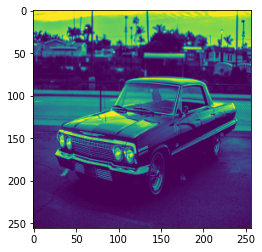

In [9]:
imgFitting = MyImageFitting(scalefactor=downscale_factor)
dataloader = DataLoader(imgFitting, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=IN_FEATURES, out_features=OUT_FEATURES, hidden_features=HIDDEN_FEATURES, 
                  hidden_layers=HIDDEN_LAYERS, outermost_linear=True)
img_siren.cuda()
img_siren.train()

# Training the SIREN

In [10]:
imageSizeH = imgFitting.side_h
imageSizeW = imgFitting.side_w

comment = f'=Omega_0={OMEGA_0}_FirstOmega_0={FIRST_OMEGA_0 }_HiddenOmega_0={HIDDEN_OMEGA_0}_Hidden_layer={HIDDEN_LAYERS}'
tb = SummaryWriter(comment=comment)

In [11]:
total_steps = TOTAL_STEPS # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

# default lr = 1e-4
if OPTIM == 'ADAM':
  optim = torch.optim.Adam(lr=LR, weight_decay=WEIGHT_DECAY, params=img_siren.parameters())
elif OPTIM == 'SGD':
  optim = torch.optim.SGD(lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, params=img_siren.parameters())
elif OPTIM == 'ADAMAX':
  optim = torch.optim.Adamax(lr=LR, weight_decay=WEIGHT_DECAY, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

tb.add_graph(img_siren, model_input)

"""
  model_input, ground_truth = next(iter(dataloader))
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

  img_gradient = gradient(model_input, ground_truth)
"""
total_loss = 0 
lst_loss = list()
lst_psnr = list()
lst_ssim = list()
best_loss = 99
best_model = -1

for step in range(total_steps):
    model_output, coords = img_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()

    if loss < best_loss:
      best_loss = loss
      best_model = copy.deepcopy(img_siren.state_dict())

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,3, figsize=(18,6))
        if RGB_MODE:
          axes[0].imshow(model_output.cpu().view(imageSizeH,imageSizeW, 3).detach().numpy())
        else:
          axes[0].imshow(model_output.cpu().view(imageSizeH,imageSizeW).detach().numpy())


        img_grad = gradient(model_output, coords)       
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(imageSizeH,imageSizeW).detach().numpy())
        del img_grad

        img_laplacian = laplace(model_output, coords)
        axes[2].imshow(img_laplacian.cpu().view(imageSizeH,imageSizeW).detach().numpy())
        del img_laplacian
        
        plt.show()

    # Gray case
    if RGB_MODE:
      psnr = peak_signal_noise_ratio(ground_truth.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy())
      ssim = structural_similarity(ground_truth.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW, 3).detach().numpy(), multichannel=True)
    else:
      psnr = peak_signal_noise_ratio(ground_truth.cpu().view(imageSizeH, imageSizeW).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW).detach().numpy())
      ssim = structural_similarity(ground_truth.cpu().view(imageSizeH, imageSizeW).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW).detach().numpy())
    
    lst_psnr.append(psnr)
    lst_ssim.append(ssim)
    lst_loss.append(loss)

    total_loss = total_loss + loss

    tb.add_scalar('Loss', loss, step)
    tb.add_scalar('Total Loss', total_loss, step)
    tb.add_scalar('PSNR', psnr, step)
    tb.add_scalar('SSIM', ssim, step)

    optim.zero_grad()
    loss.backward()
    optim.step()

if RGB_MODE is False:
  ok = model_output.cpu().view(imageSizeH,imageSizeW).detach().numpy()
  tb.add_image('SIREN Training',ok, dataformats='HW')

Output hidden; open in https://colab.research.google.com to view.

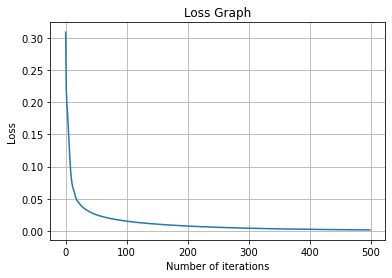

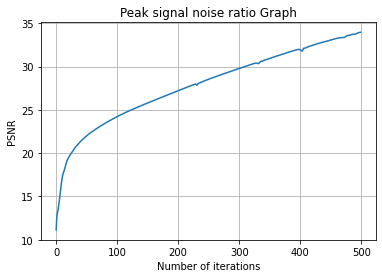

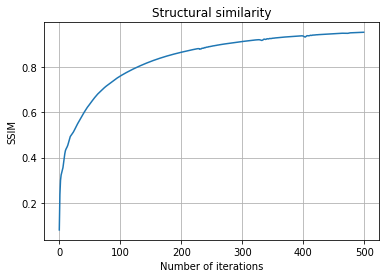

In [12]:
fig = plt.figure()
plt.errorbar(range(0, total_steps), lst_loss, label='Loss')
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.grid(True)
plt.show()

fig = plt.figure()
plt.errorbar(range(0, total_steps), lst_psnr, label='PSNR')
plt.title('Peak signal noise ratio Graph')
plt.ylabel('PSNR')
plt.xlabel('Number of iterations')
plt.grid(True)
plt.show()

fig = plt.figure()
plt.errorbar(range(0, total_steps), lst_ssim, label='SSIM')
plt.title('Structural similarity')
plt.ylabel('SSIM')
plt.xlabel('Number of iterations')
plt.grid(True)
plt.show()

# Comparing output SIREN with ground truth (downscaling case)

PSNR:  33.96249764900403
SSIM:  0.9531975844926605


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


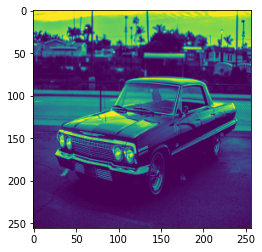

In [13]:
img = load_image(downscale_factor)

if RGB_MODE:
  psnr = peak_signal_noise_ratio(img.view(imageSizeH, imageSizeW, 3).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeH, 3).detach().numpy())
  ssim = structural_similarity(img.view(imageSizeH, imageSizeW, 3).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeH, 3).detach().numpy(), multichannel=True)
else:
  psnr = peak_signal_noise_ratio(img.view(imageSizeH, imageSizeW).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW).detach().numpy())
  ssim = structural_similarity(img.view(imageSizeH, imageSizeW).detach().numpy(), model_output.cpu().view(imageSizeH, imageSizeW).detach().numpy())

string = 'PSRN=' + str(psnr) + '  SSIM=' + str(ssim)
tb.add_text('Siren Training Ouput vs Ground Truth PSNR and SSIM', string)

print('PSNR: ', psnr)
print('SSIM: ',ssim)

# Predict the upscaling image

In [14]:
img_siren.load_state_dict(best_model)
print('Load model with best loss {}'.format(best_loss))

img_siren.eval()

Load model with best loss 0.0016062392387539148


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([512])
torch.Size([512])


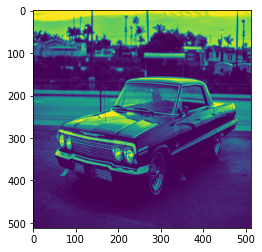

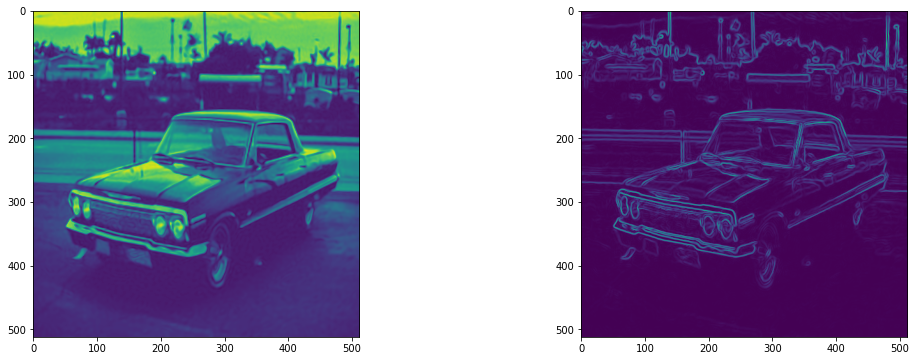

In [15]:
bigImageSizeH = imageSizeH * upscale_factor
bigImageSizeW = imageSizeW * upscale_factor

img_input = MyImageFitting(downscale_factor * upscale_factor, activate_blur=False)
dataloader = DataLoader(img_input, batch_size=1, pin_memory=True, num_workers=0)

model_input1, ground_truth1 = next(iter(dataloader))
del ground_truth1

model_output1, coords = img_siren(model_input1.cuda())

fig, axes = plt.subplots(1,2, figsize=(18,6))
if RGB_MODE:
  axes[0].imshow(model_output1.cpu().view(bigImageSizeH,bigImageSizeW, 3).detach().numpy())
else:
  axes[0].imshow(model_output1.cpu().view(bigImageSizeH,bigImageSizeW).detach().numpy())

img_grad = gradient(model_output1, coords)        
axes[1].imshow(img_grad.norm(dim=-1).cpu().view(bigImageSizeH,bigImageSizeW).detach().numpy())
del img_grad

# Calculate PSNR and SSIM on the upscaled image

PSNR:  29.429432197533572
SSIM:  0.8793300430447307


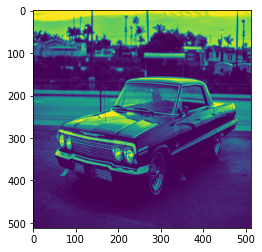

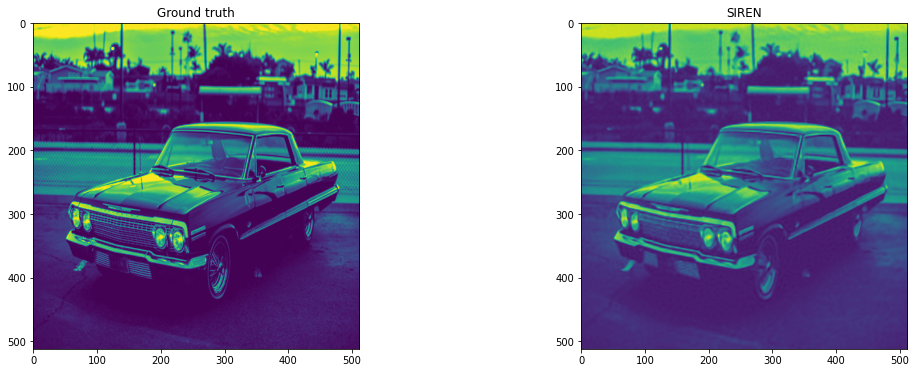

In [16]:
img = load_image(downscale_factor * upscale_factor)

if RGB_MODE:
  psnr = peak_signal_noise_ratio(img.squeeze().permute(1, 2, 0).numpy(), model_output1.cpu().view(bigImageSizeH, bigImageSizeW, 3).detach().numpy())
  ssim = structural_similarity(img.squeeze().permute(1, 2, 0).numpy(), model_output1.cpu().view(bigImageSizeH, bigImageSizeW, 3).detach().numpy(), multichannel=True)
else:
  psnr = peak_signal_noise_ratio(img.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), model_output1.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())
  ssim = structural_similarity(img.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), model_output1.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), multichannel=True)
print('PSNR: ', psnr)
print('SSIM: ', ssim)

fig, axes = plt.subplots(1,2, figsize=(18,6))
if RGB_MODE:
  axes[0].imshow(img.squeeze().permute(1, 2, 0))
else:
  axes[0].imshow(img.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())
axes[0].set_title('Ground truth')
if RGB_MODE:
  axes[1].imshow(model_output1.cpu().view(bigImageSizeH, bigImageSizeW, 3).detach().numpy())
else:     
  axes[1].imshow(model_output1.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())
axes[1].set_title('SIREN')

string = 'PSRN=' + str(psnr) + '  SSIM=' + str(ssim)
tb.add_text('Siren Upscale vs Ground Truth PSNR and SSIM', string)

if RGB_MODE is False:
  ok = model_output1.cpu().view(bigImageSizeH,bigImageSizeW).detach().numpy()
  tb.add_image('SIREN Super Resolution',ok, dataformats='HW')

# Comparing with upsaming Bicubic

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


PSNR:  30.36536111185109
SSIM:  0.940669350886831


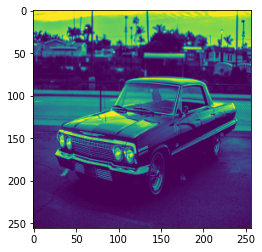

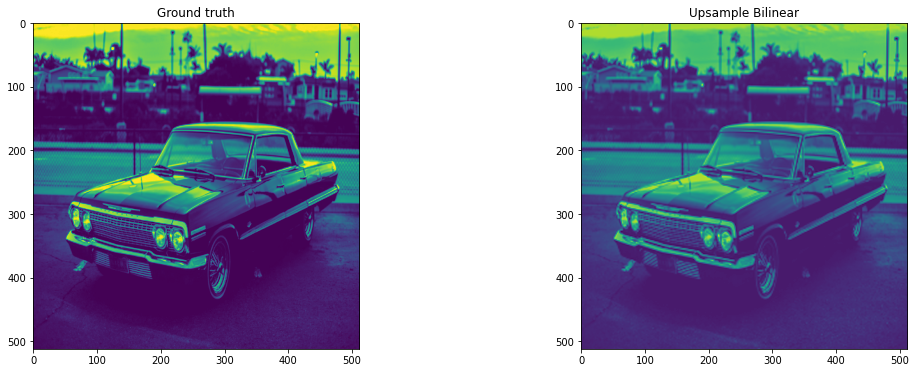

In [17]:
from torch.nn import Upsample

ground_truth = load_image(downscale_factor * upscale_factor)
img = load_image(downscale_factor)
if RGB_MODE:
  img = img.view(1, 3, img.shape[1], img.shape[2])
else:
  img = img.view(1, 1, img.shape[1], img.shape[2])

m = nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=True)
my_output = m(img)

if RGB_MODE:
  psnr = peak_signal_noise_ratio(ground_truth.view(bigImageSizeH, bigImageSizeW, 3).numpy(), my_output.view(bigImageSizeH, bigImageSizeW, 3).numpy())
  ssim = structural_similarity(ground_truth.view(bigImageSizeH, bigImageSizeW, 3).numpy(), my_output.view(bigImageSizeH, bigImageSizeW, 3).numpy(), multichannel=True)
else:
  psnr = peak_signal_noise_ratio(ground_truth.view(bigImageSizeH, bigImageSizeW).numpy(), my_output.view(bigImageSizeH, bigImageSizeW).numpy())
  ssim = structural_similarity(ground_truth.view(bigImageSizeH, bigImageSizeW).numpy(), my_output.view(bigImageSizeH, bigImageSizeW).numpy())
print('PSNR: ', psnr)
print('SSIM: ', ssim)

fig, axes = plt.subplots(1,2, figsize=(18,6))
if RGB_MODE:
  axes[0].imshow(ground_truth.cpu().squeeze().permute(1, 2, 0))
else:
  axes[0].imshow(ground_truth.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())

axes[0].set_title('Ground truth')

if RGB_MODE:
  axes[1].imshow(my_output.squeeze().permute(1, 2, 0))
else:
  axes[1].imshow(my_output.view(bigImageSizeH, bigImageSizeW).detach().numpy())
axes[1].set_title('Upsample Bilinear') 

string = 'PSRN=' + str(psnr) + '  SSIM=' + str(ssim)
tb.add_text('Bicubic Upscale vs Ground Truth PSNR and SSIM', string)

if RGB_MODE:
  ok = my_output.view(bigImageSizeH,bigImageSizeW, 3).detach().numpy()
else:
  ok = my_output.view(bigImageSizeH,bigImageSizeW).detach().numpy()
  
if RGB_MODE is False:
  tb.add_image('Bicubic Upscale',ok, dataformats='HW')
  tb.close()

In [18]:
if EQN_POISSON is False:
  sys.exit()

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Poisson Equation

In [10]:
import scipy.ndimage
    
class PoissonEqn(Dataset):
    def __init__(self, downscale_factor):
        super().__init__()
        #img = get_cameraman_tensor(sidelength)
        img = load_image(downscale_factor)
        self.side_h = img.shape[1]
        self.side_w = img.shape[2]

        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = my_get_mgrid(self.side_h, self.side_w, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}

torch.Size([256])
torch.Size([256])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

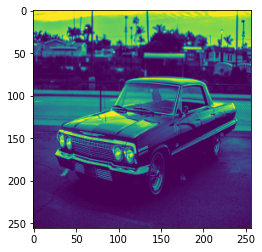

In [11]:
img_poisson = PoissonEqn(downscale_factor)
dataloader = DataLoader(img_poisson, batch_size=1, pin_memory=True, num_workers=0)

poisson_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                      hidden_layers=3, outermost_linear=True)
poisson_siren.cuda()

In [12]:
def gradients_mse(model_output, coords, gt_gradients):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
    return gradients_loss

In [13]:
imageSizeH = img_poisson.side_h
imageSizeW = img_poisson.side_w

In [14]:
total_steps = 1000
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=poisson_siren.parameters())

model_input, gt = next(iter(dataloader))
gt = {key: value.cuda() for key, value in gt.items()}
model_input = model_input.cuda()

for step in range(total_steps):
    start_time = time.time()

    model_output, coords = poisson_siren(model_input)
    train_loss = gradients_mse(model_output, coords, gt['grads'])

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f, iteration time %0.6f" % (step, train_loss, time.time() - start_time))

        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(model_output.cpu().view(imageSizeH,imageSizeW).detach().numpy())
        axes[1].imshow(img_grad.cpu().norm(dim=-1).view(imageSizeH,imageSizeW).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(imageSizeH,imageSizeW).detach().numpy())
        plt.show()
    
    optim.zero_grad()
    train_loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

# Predict the upscaled image

torch.Size([512])
torch.Size([512])


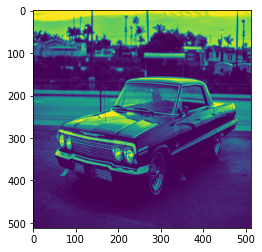

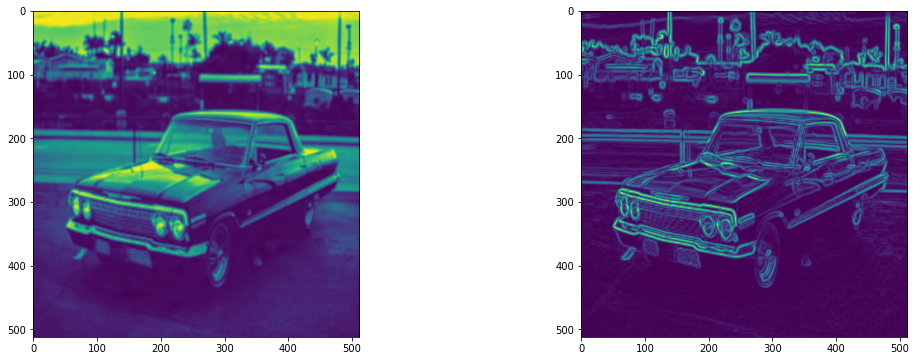

In [15]:
bigImageSizeH = imageSizeH * upscale_factor
bigImageSizeW = imageSizeW * upscale_factor

img_input = MyImageFitting(downscale_factor * upscale_factor, activate_blur=False)
dataloader = DataLoader(img_input, batch_size=1, pin_memory=True, num_workers=0)

model_input, gt = next(iter(dataloader))
model_input = model_input.cuda()
model_output, coords = poisson_siren(model_input)

fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].imshow(model_output.cpu().view(bigImageSizeH,bigImageSizeW).detach().numpy())

img_grad = gradient(model_output, coords)        
axes[1].imshow(img_grad.norm(dim=-1).cpu().view(bigImageSizeH,bigImageSizeW).detach().numpy())
del img_grad

# Evaluate the Poisson prediction

PSNR:  11.979676556092167
SSIM:  0.22276607799728618


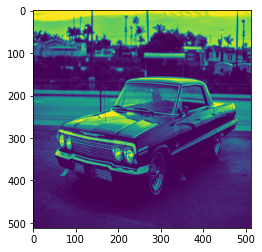

In [16]:
ground_truth = load_image(downscale_factor * upscale_factor)

psnr = peak_signal_noise_ratio(ground_truth.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), model_output.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())
ssim = structural_similarity(ground_truth.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy(), model_output.cpu().view(bigImageSizeH, bigImageSizeW).detach().numpy())

print('PSNR: ', psnr)
print('SSIM: ', ssim)